# Stem cell function and disease progression in muscular dystrophy using injured mouse model

In [ ]:
pip install scanpy scrublet seaborn matplotlib pandas numpy scikit-learn gseapy

In [249]:
import os
import skimage
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

In [250]:
## Set scanpy verbosity
sc.settings.verbosity = 3

## Load and pre-process the data

In [251]:
project_path = "/Users/Swarnali_1/Stem-cell-function-and-disease-progression-in-muscular-dystrophy-using-injured-mouse-model/data/"

samples = {"not_injured" : "GSM8289594_QSC_GFP_filtered_feature_bc_matrix.h5",
"injured" : "GSM8289595_ASC_GFP_filtered_feature_bc_matrix.h5"}

adatas = {}

for sample_id, file_id in samples.items():
    path = os.path.join(project_path, file_id)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

for sample_id, sample in adatas.items():
    print(f"Sample Name: {sample_id}, Sample: {sample}")

adata = ad.concat(adatas, label = "sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())

reading /Users/Swarnali_1/Stem-cell-function-and-disease-progression-in-muscular-dystrophy-using-injured-mouse-model/data/GSM8289594_QSC_GFP_filtered_feature_bc_matrix.h5
 (0:00:01)
reading /Users/Swarnali_1/Stem-cell-function-and-disease-progression-in-muscular-dystrophy-using-injured-mouse-model/data/GSM8289595_ASC_GFP_filtered_feature_bc_matrix.h5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Sample Name: not_injured, Sample: AnnData object with n_obs × n_vars = 8449 × 32285
    var: 'gene_ids', 'feature_types', 'genome'
Sample Name: injured, Sample: AnnData object with n_obs × n_vars = 6429 × 32285
    var: 'gene_ids', 'feature_types', 'genome'
sample
not_injured    8449
injured        6429
Name: count, dtype: int64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [252]:
## Look at the count of unique values in the "sample" column of the obs
print(adata.obs.value_counts())
print(adata.obs["sample"].value_counts())

sample     
not_injured    8449
injured        6429
Name: count, dtype: int64
sample
not_injured    8449
injured        6429
Name: count, dtype: int64


## Quality Control

In [253]:

## Mitochondrial content
adata.var["mt"] = adata.var_names.str.startswith("mt-")
mito_genes = adata.var_names.str.startswith("mt-")

## Ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith("Rps", "Rpl")
ribo_genes = adata.var_names.str.startswith("Rps-")

## Hemoglobin genes
adata.var["hb"] = adata.var_names.str.startswith("^Hb[^(P)]")
hb_genes = adata.var_names.str.contains('^Hb[^(P)]')

## Calculate quality control metrics
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=False
)

## Calculate percent of mitochondrial content
#adata.obs["percent_mt2"] = np.sum(
    #adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

## Calculate percent of ribosomal content
#adata.obs["percent_ribo"] = np.sum(adata[:,ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

## Calculate total counts for each cell
adata.obs["n_counts"] = adata.X.sum(axis=1).A1

print(adata.obs)

                         sample  n_genes_by_counts  total_counts  \
AAACCCAAGAGATTCA-1  not_injured               3130        8428.0   
AAACCCAAGGAATGTT-1  not_injured               3049        7313.0   
AAACCCACAAATTAGG-1  not_injured               1345        2747.0   
AAACCCACATACTGAC-1  not_injured               1644        3358.0   
AAACCCACATAGATGA-1  not_injured               1429        2711.0   
...                         ...                ...           ...   
TTTGTTGGTTTCGCTC-1      injured               2597        7032.0   
TTTGTTGTCAAGGCTT-1      injured               1933        4390.0   
TTTGTTGTCCGATCGG-1      injured               3108        9870.0   
TTTGTTGTCCTATTTG-1      injured               3072        8476.0   
TTTGTTGTCGAATGCT-1      injured               3630       11109.0   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACCCAAGAGATTCA-1                   26.506882                    37.980541   
AAACCCAAGGAATGTT-1       

In [ ]:
## Visualize quality metrics using violin plot
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "percent_mt2"],
    jitter=0.4,
    multi_panel=True,
)
## Visualize quality metrics using scatter plot
sc.pl.scatter(
    adata, 
    "total_counts", "n_genes_by_counts", 
    color = "percent_mt2"
)

This dataset does not have any mitochondrial, ribosomal or hemoglobin content to filter out; However, it always helps to visualize these quality metrics to ensure the quality looks fine before going ahead.

In [254]:
## Filter out cells that have at least 200 genes with values
sc.pp.filter_cells(adata, min_genes = 100)
## Filter out genes that have counts in at least 3 cells 
sc.pp.filter_genes(adata, min_cells = 3)

print(adata.n_obs, adata.n_vars)

filtered out 254 cells that have less than 100 genes expressed
filtered out 10028 genes that are detected in less than 3 cells
14624 22257


normalizing counts per cell
    finished (0:00:00)


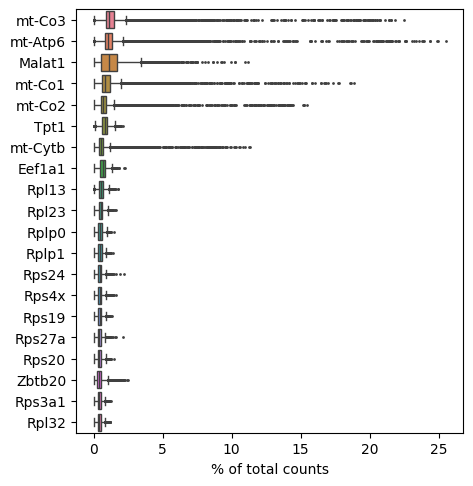

In [255]:
sc.pl.highest_expr_genes(adata, n_top = 20)

Since some of the mitochondrial genes are being expressed highly, we need to rmeove them.

In [257]:
## Mitochondrial and ribosomal filtering
adata = adata[adata.obs["pct_counts_mt"] < 20, :]
adata = adata[adata.obs["pct_counts_ribo"] > 5, :]
print("Remaining cells %d"%adata.n_obs)

print(adata.obs.columns)
#print(adata.obs["pct_counts_mt"])
#print(adata.var[adata.var["mt"] == True])

Remaining cells 12867
Index(['sample', 'n_genes_by_counts', 'total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_counts',
       'n_genes'],
      dtype='object')


In [259]:
## Gene based filtering
genes_to_remove = np.add(mito_genes, "Malat1")
genes_to_remove = np.add(genes_to_remove, ribo_genes)
keep = np.invert(genes_to_remove)

adata_filtered = adata[:, keep]
print(adata_filtered.n_obs, adata_fitlered.n_vars)


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('bool'), dtype('<U6')) -> None

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


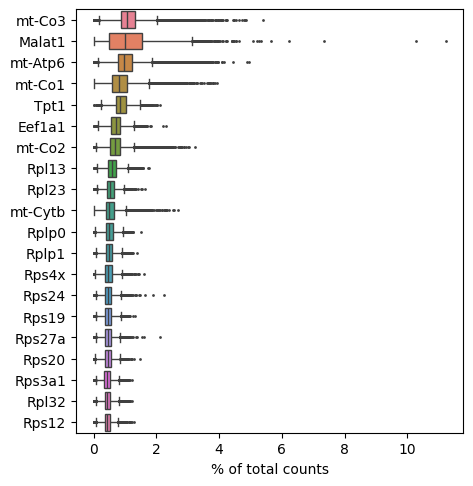

## Doublet Detection

In [ ]:
##sc.pp.scrublet(adata, batch_key="sample")

## Data Normalization
It is normal practice to log transform the values such that the gene counts are uniform across the cells. 

In [ ]:
##Save the view into a variable
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

## Feature Selection
Here, in order to reduce the size of the data and keep only highly variable genes, we will perform feature selection. 

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
## Plot the variable genes
sc.pl.highly_variable_genes(adata)

## Dimensional Reduction
Here we reduce the dimensionality of the data by summarizing the maximum variance in the form of principal components. 

computing PCA
    with n_comps=50
    finished (0:00:25)


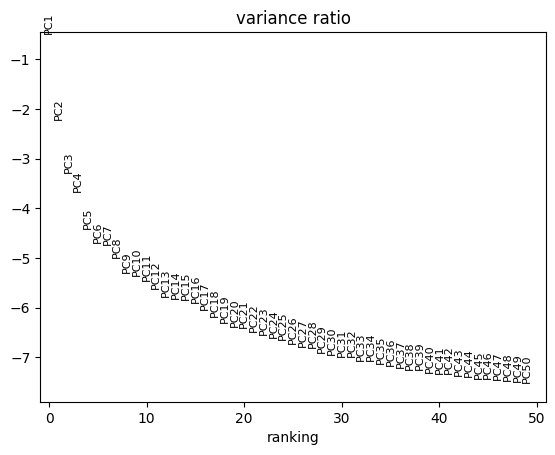

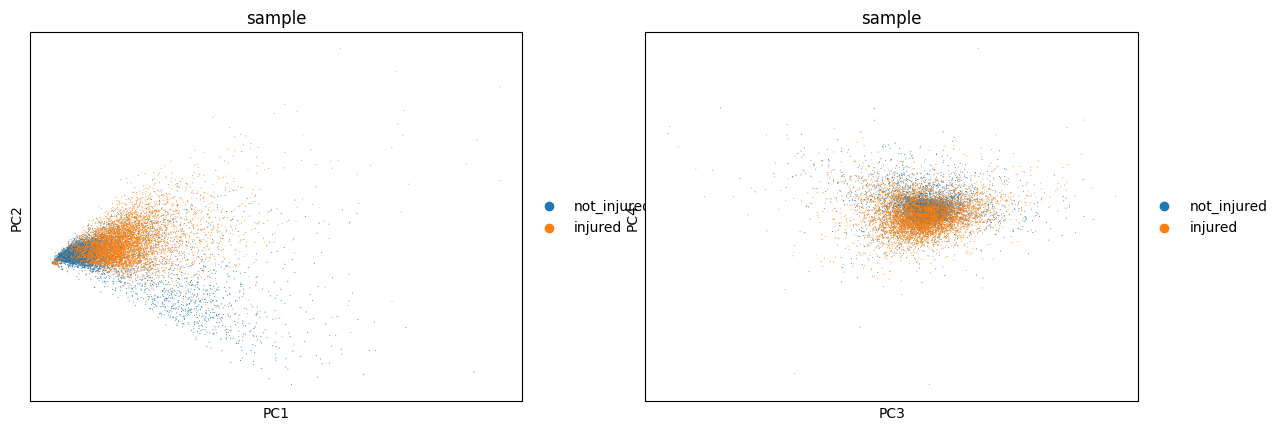

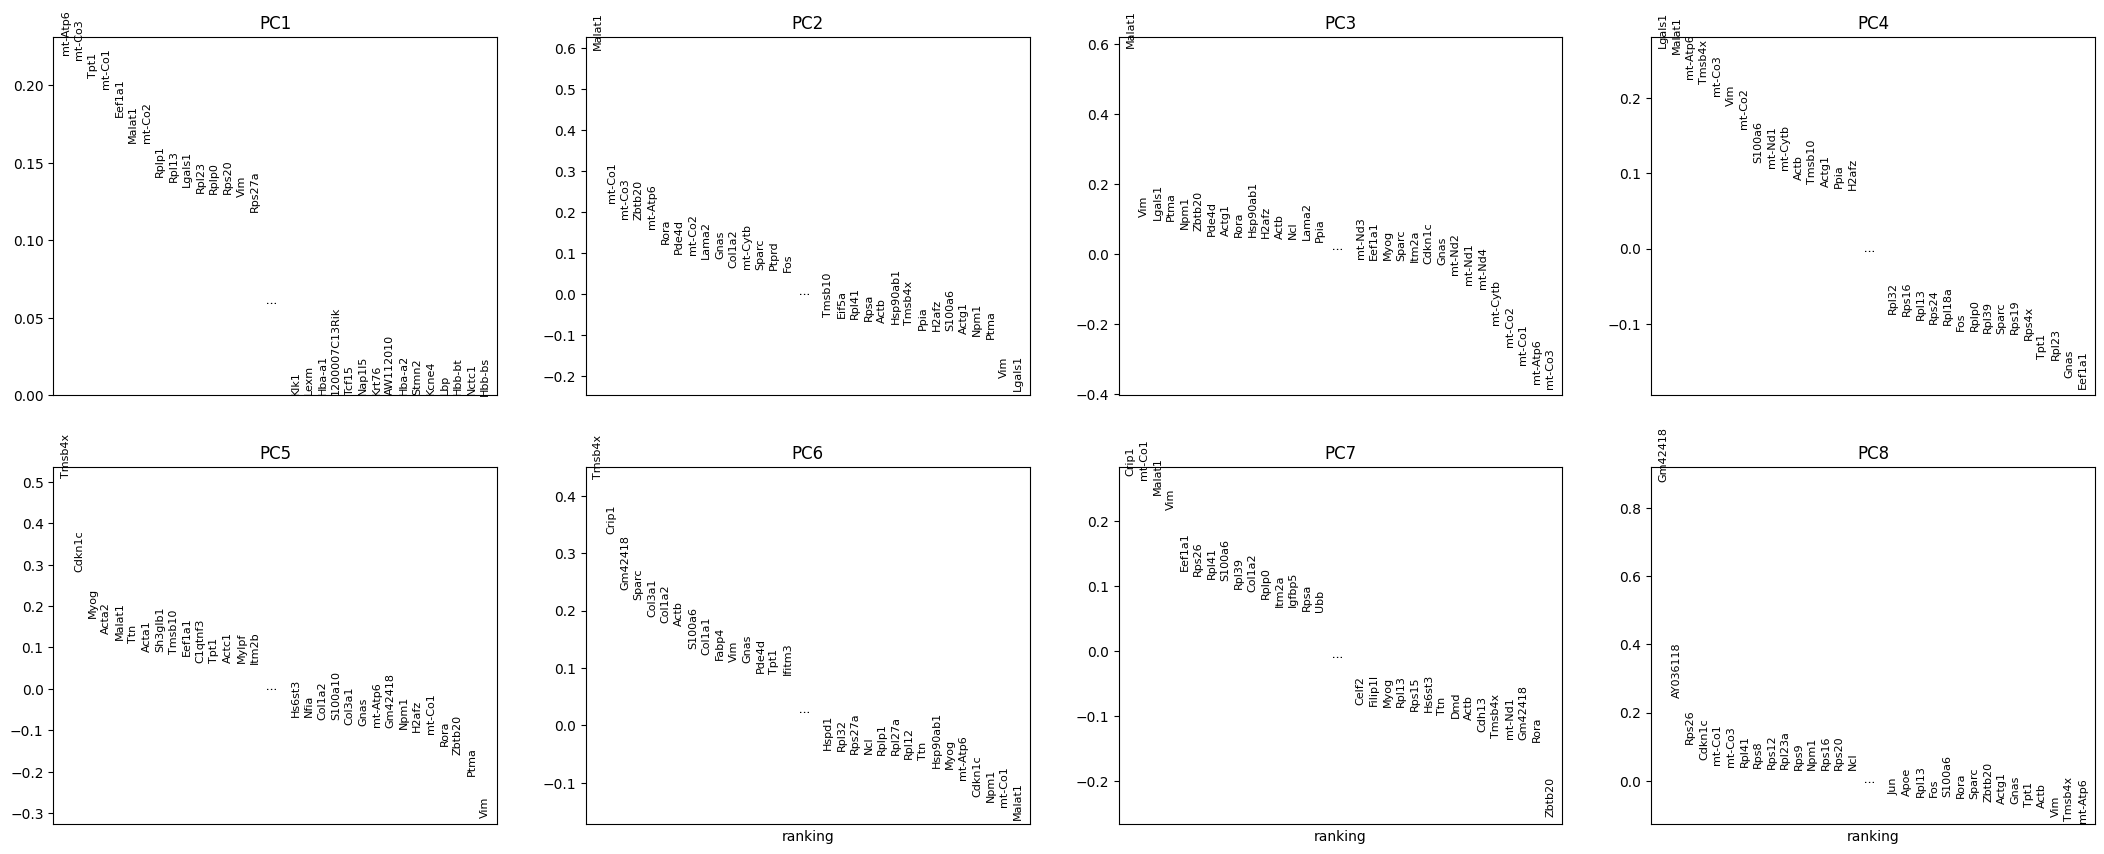

In [260]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
sc.pl.pca(
    adata,
    color=["sample", "sample"],
    dimensions=[(0, 1), (2, 3)],
    ncols=2,
    size=2,
)
sc.pl.pca_loadings(adata, components=[1,2,3,4,5,6,7,8])

## Nearest neighbor graph construction

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:07)


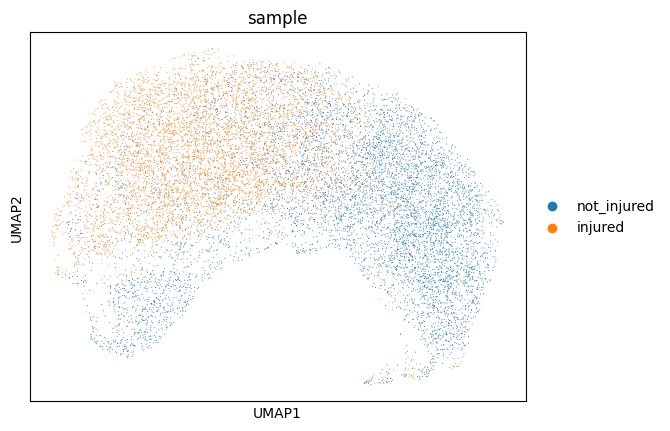

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:08)


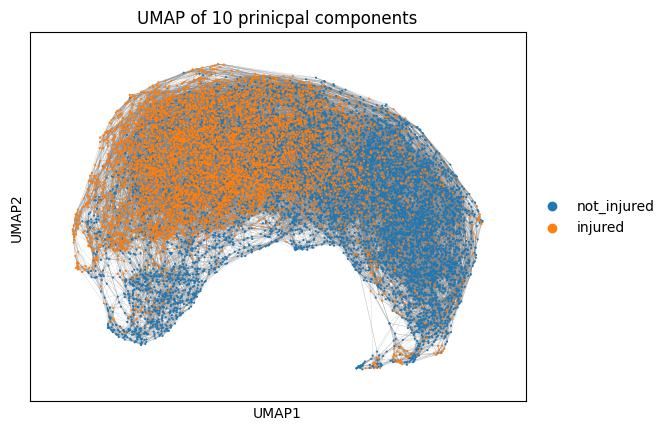

In [261]:
## Use PCA to construct nearest neighbors graph
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 30)


# UMAP

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)


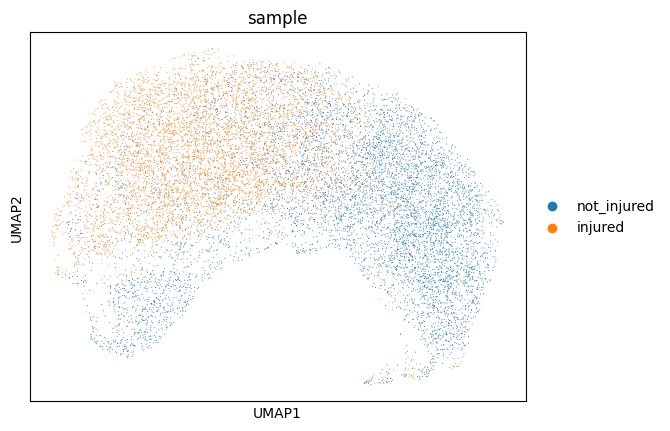

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:08)


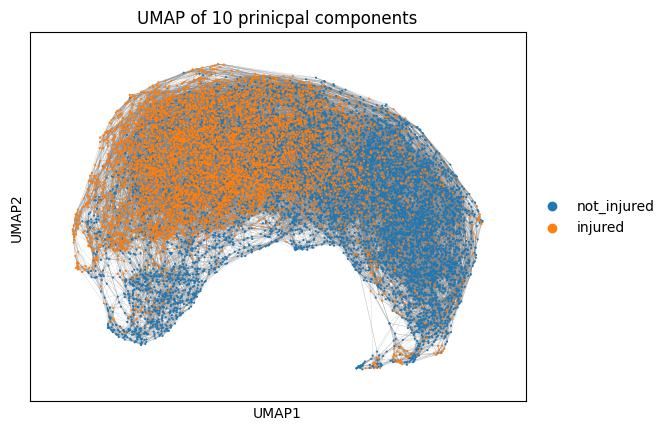

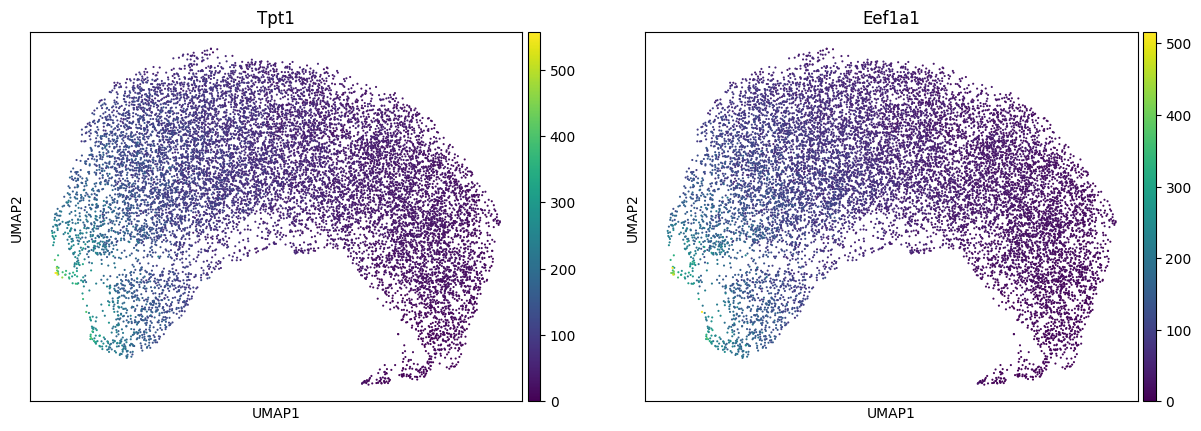

In [265]:
## Embed this graph into the object in the form of UMAP
sc.tl.umap(adata)

## Visualize
sc.pl.umap(
    adata,
    color = "sample",
    size = 2,
)

## Calculate UMAP for 10 components
umap10 = sc.tl.umap(adata, n_components = 10, copy = True)
sc.pl.umap(adata,
color = "sample",
title = "UMAP of 10 prinicpal components",
edges = True)

## Visualize UMAP for genes of interest
sc.pl.umap(adata,
color = ["Tpt1", "Eef1a1"])

# TSNE

computing tSNE
    using 'X_pca' with n_pcs = 30
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm)
    'tsne', tSNE parameters (adata.uns) (0:01:33)


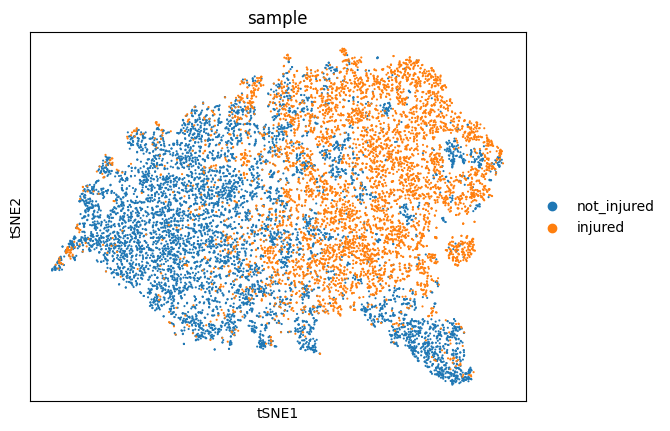

In [263]:
## Use graph for TSNE reductions
sc.tl.tsne(adata, n_pcs = 30)

## Visualize
sc.pl.tsne(adata, color = "sample")

## Clustering
We use Leiden graph-clustering method to cluster the cells using the neighbor graph.

running Leiden clustering


/var/folders/ww/l8xw9y1n1hg7p7wt3cpmd1ph0000gp/T/ipykernel_55443/213849273.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added = "leiden_1.0")


    finished: found 19 clusters and added
    'leiden_1.0', the cluster labels (adata.obs, categorical) (0:00:06)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden_0.6', the cluster labels (adata.obs, categorical) (0:00:05)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_0.4', the cluster labels (adata.obs, categorical) (0:00:07)
running Leiden clustering
    finished: found 24 clusters and added
    'leiden_1.4', the cluster labels (adata.obs, categorical) (0:00:08)


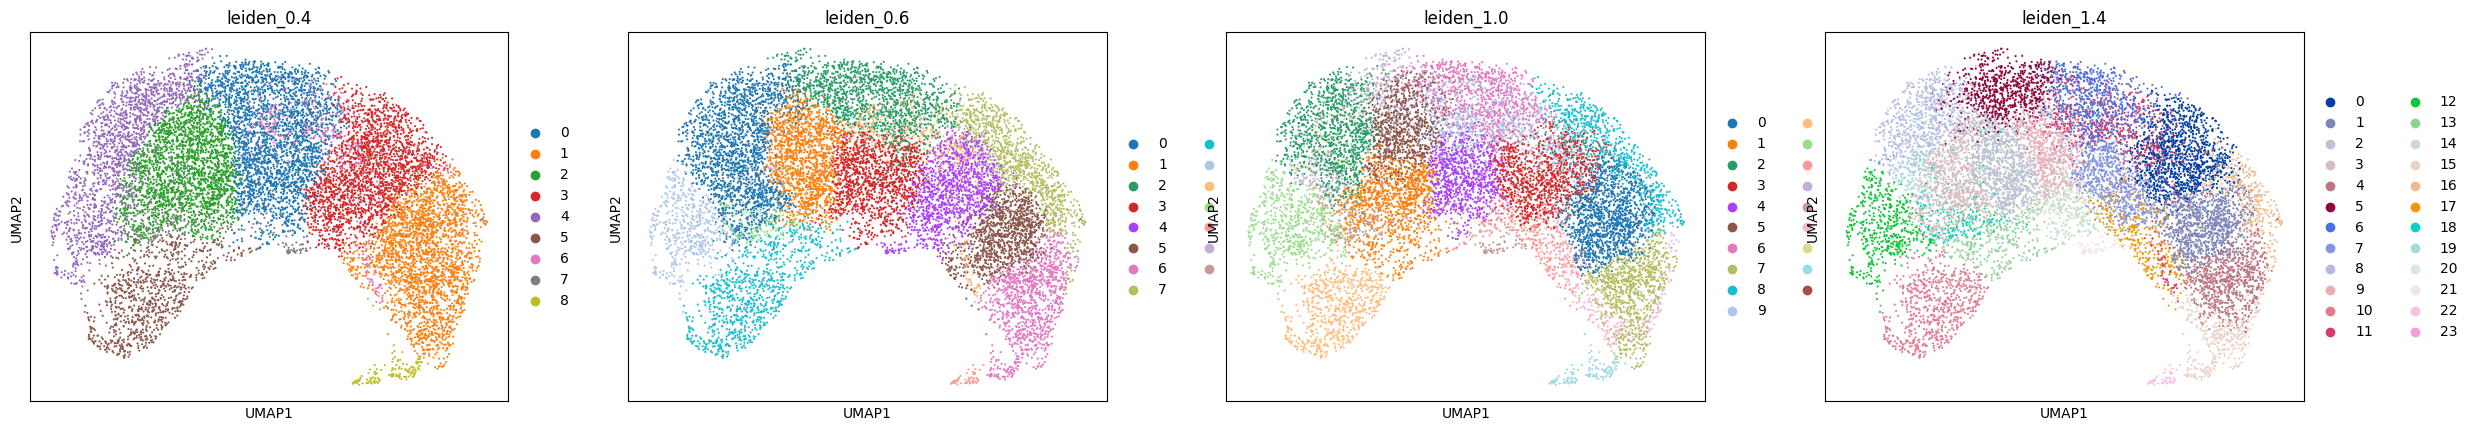

In [275]:
sc.tl.leiden(adata, key_added = "leiden_1.0") 
sc.tl.leiden(adata, resolution = 0.6, key_added = "leiden_0.6")
sc.tl.leiden(adata, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata, resolution = 1.4, key_added = "leiden_1.4")
# Visualize
sc.pl.umap(adata, color=['leiden_0.4', 'leiden_0.6', 'leiden_1.0','leiden_1.4'])


In [274]:
pip install leidenalg

  Obtaining dependency information for leidenalg from https://files.pythonhosted.org/packages/82/90/0b9525098a7458939f5c2b956ffdc1fed460c0fe706f549087c3b0d12b81/leidenalg-0.10.2-cp38-abi3-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Detect the highly variable genes

In [269]:
#sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'sample')
#sc.pp.highly_variable_genes(adata)

print(adata.var.columns)

Index(['mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'n_cells'],
      dtype='object')


## Cell annotation
